In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-06-17 19:56:12.396761: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-17 19:56:12.503891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-17 19:56:12.503969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-17 19:56:12.518506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 19:56:12.563815: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=224
BATCH_SIZE=32
DATA_PATH="../../data/processed/04_kaggle_dataset"

datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 8032 images belonging to 2 classes.
Found 2007 images belonging to 2 classes.


In [3]:
# ResNet50 모델 정의
base_model=ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable=False  # 전체 freeze

model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#model.summary()

2025-06-17 19:56:25.407565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-17 19:56:25.407661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-17 19:56:25.407700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-17 19:56:25.608799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-17 19:56:25.608921: I external/local_xla/xla/stream_executor

In [4]:
save_path="../../src/models/20_resnet50/best_model.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
esc=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
mcp=ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True, verbose=1)

In [5]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, callbacks=[esc, mcp])

Epoch 1/20


2025-06-17 19:57:06.415248: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-17 19:57:06.617407: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-17 19:57:06.617455: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-17 19:57:06.617611: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-17 19:57:07.770888: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-17 19:57:09.451375: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

  1/251 [..............................] - ETA: 22:10 - loss: 0.6796 - accuracy: 0.5312

2025-06-17 19:57:09.928211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-17 19:57:09.985781: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:408] Couldn't read CUDA driver version.
I0000 00:00:1750157829.998475   22734 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5510
Epoch 1: val_loss improved from inf to 0.66019, saving model to ../../src/models/20_resnet50/best_model.keras
251/251 [==============================] - 60s 218ms/step - loss: 0.6872 - accuracy: 0.5510 - val_loss: 0.6602 - val_accuracy: 0.6213
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.6356
Epoch 2: val_loss improved from 0.66019 to 0.61395, saving model to ../../src/models/20_resnet50/best_model.keras
251/251 [==============================] - 50s 199ms/step - loss: 0.6472 - accuracy: 0.6356 - val_loss: 0.6140 - val_accuracy: 0.7170
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.6799
Epoch 3: val_loss improved from 0.61395 to 0.57442, saving model to ../../src/models/20_resnet50/best_model.keras
251/251 [==============================] - 49s 195ms/step - loss: 0.6074 - accuracy: 0.6799 - val_loss: 0.5744 - val_

# 파인튜닝

In [10]:
from tensorflow.keras.optimizers import Adam

base_model=ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# 기존 layer들을 모두 학습 가능하도록 설정
for layer in base_model.layers:
    layer.trainable=True

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512, activation="relu")(x)
x=Dropout(0.3)(x)
output=Dense(1, activation="sigmoid")(x)

finetuned_model=Model(inputs=base_model.input, outputs=output)
finetuned_model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_path="../../src/models/20_resnet50/resnet50_finetuned_best_model.keras"

mcp=ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True, verbose=1)
es=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reducelr=ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

In [12]:
history=finetuned_model.fit(train_generator, validation_data=val_generator,
                            epochs=20, callbacks=[mcp, es, reducelr])

Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9143
Epoch 1: val_loss improved from inf to 0.79212, saving model to ../../src/models/20_resnet50/resnet50_finetuned_best_model.keras
251/251 [==============================] - 83s 248ms/step - loss: 0.2229 - accuracy: 0.9143 - val_loss: 0.7921 - val_accuracy: 0.4983 - lr: 1.0000e-05
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9584
Epoch 2: val_loss did not improve from 0.79212
251/251 [==============================] - 59s 232ms/step - loss: 0.1249 - accuracy: 0.9584 - val_loss: 1.1021 - val_accuracy: 0.4983 - lr: 1.0000e-05
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9653
Epoch 3: val_loss did not improve from 0.79212

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
251/251 [==============================] - 58s 232ms/step - loss: 0.1017 - accuracy: 0.9653 - val_loss: 1.0472

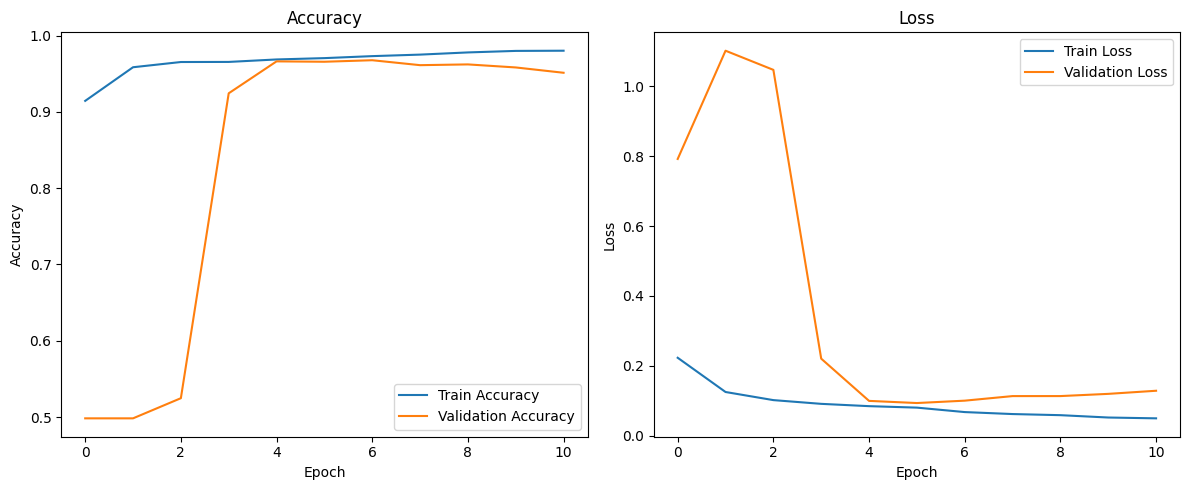

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
#plt.savefig("../../results/images/20_resnet_finetuned_training_plot.png")
plt.show()

In [ ]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print("=== Classification Report ===")
print(report)

# report_path="../../results/reports/20_resnet50_finetuned_classification_report.txt"
# with open(report_path, "w") as f:
#     f.write(report)

=== Classification Report ===
              precision    recall  f1-score   support

      closed       0.76      0.91      0.83      1000
        open       0.89      0.72      0.80      1007

    accuracy                           0.81      2007
   macro avg       0.83      0.81      0.81      2007
weighted avg       0.83      0.81      0.81      2007



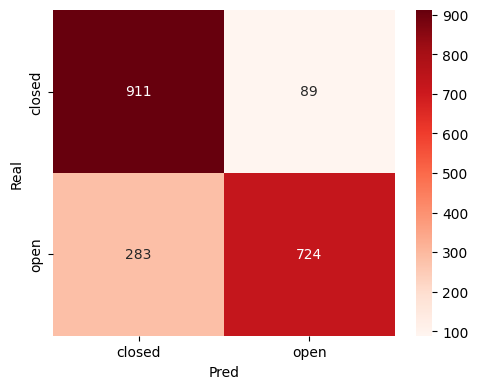

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
# plt.savefig("../../results/images/20_resnet50finetuned_confusion_matrix.png")
plt.show()